In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
# device configuration
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.') 
    device = torch.device('cpu')

Using PyTorch version: 2.4.0+cu124
Using GPU, device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
from load_datasets import load_mnist

train_dataset, test_dataset = load_mnist()

In [4]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) for image classification.

    Attributes:
        fc1 (nn.Linear): First fully connected layer.
        relu (nn.ReLU): ReLU activation function.
        fc2 (nn.Linear): Second fully connected layer for output.
    """

    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()                           # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second fully connected layer

    def forward(self, x):
        # Flatten the image 
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)       # No activation here; we'll apply softmax in the loss function
        return out, x


In [5]:
input_size = 28*28
hidden_size = 500
num_classes = 10

In [6]:
untrained_model = MLP(input_size, hidden_size, num_classes).to(device)
trained_model = MLP(input_size, hidden_size, num_classes).to(device)

# load the trained model
trained_model.load_state_dict(torch.load('./models/mlp_model_98_27.ckpt'))

trained_model.eval()
untrained_model.eval()

C:\Users\Shardul Junagade\AppData\Local\Temp\ipykernel_20032\1947326766.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load('./model

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [7]:
def get_hidden_layer_output(model, dataset, device=device):
    hidden_layer_output = []
    labels = []
    with torch.no_grad():
        for image, label in dataset:
            image = image.to(device).view(1, -1)  # Flatten image
            _, hidden_output = model(image)  # Get hidden layer output
            hidden_layer_output.append(hidden_output.squeeze().cpu().numpy())
            labels.append(label)
    return np.array(hidden_layer_output), np.array(labels)

X_trained, y_trained = get_hidden_layer_output(trained_model, test_dataset)
X_untrained, y_untrained = get_hidden_layer_output(untrained_model, test_dataset)

## openTSNE

In [8]:
from openTSNE import TSNE
# Perform Barnes-Hut t-SNE on the hidden layer output
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
X_trained_tsne = tsne.fit(X_trained)
X_untrained_tsne = tsne.fit(X_untrained)

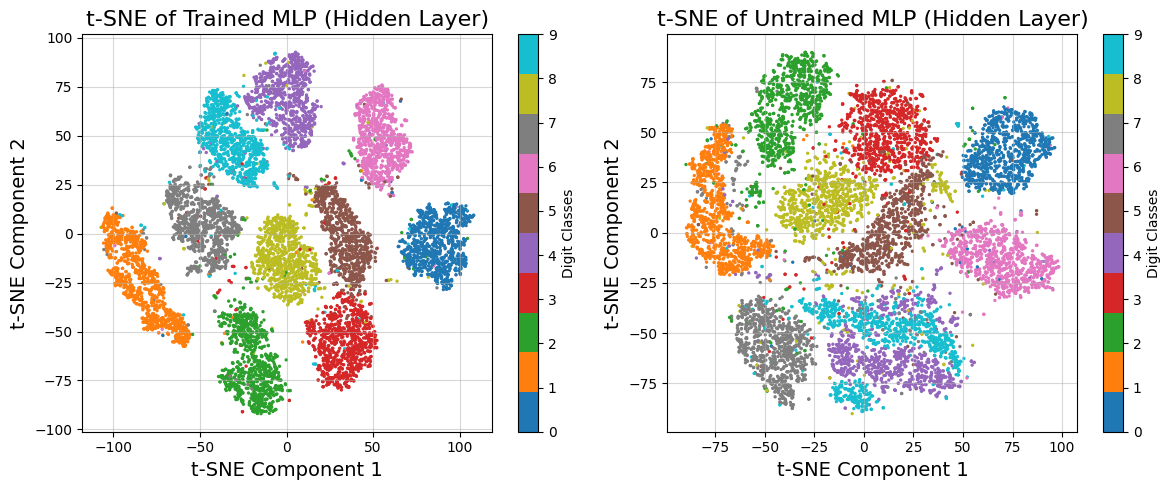

In [9]:
# Plotting t-SNE for trained and untrained models
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter1 = axes[0].scatter(X_trained_tsne[:, 0], X_trained_tsne[:, 1], c=y_trained, cmap='tab10', alpha=1, s=2)
axes[0].set_title('t-SNE of Trained MLP (Hidden Layer)', fontsize=16)
axes[0].set_xlabel('t-SNE Component 1', fontsize=14)
axes[0].set_ylabel('t-SNE Component 2', fontsize=14)
axes[0].grid(True,  alpha=0.5)
fig.colorbar(scatter1, ax=axes[0], label='Digit Classes')

scatter2 = axes[1].scatter(X_untrained_tsne[:, 0], X_untrained_tsne[:, 1], c=y_untrained, cmap='tab10', alpha=1, s=2)
axes[1].set_title('t-SNE of Untrained MLP (Hidden Layer)', fontsize=16)
axes[1].set_xlabel('t-SNE Component 1', fontsize=14)
axes[1].set_ylabel('t-SNE Component 2', fontsize=14)
axes[1].grid(True, alpha=0.5)
fig.colorbar(scatter2, ax=axes[1], label='Digit Classes')

plt.tight_layout()
plt.show()


## Sk Learn's TSNE

In [12]:
from sklearn.manifold import TSNE as SK_TSNE

# Perform t-SNE on the hidden layer output
tsne = SK_TSNE(n_components=2, perplexity=30, n_iter=300, method='barnes_hut', random_state=0)
X_trained_sk_tsne = tsne.fit_transform(X_trained)
X_untrained_sk_tsne = tsne.fit_transform(X_untrained)

C:\Users\Shardul Junagade\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\Shardul Junagade\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


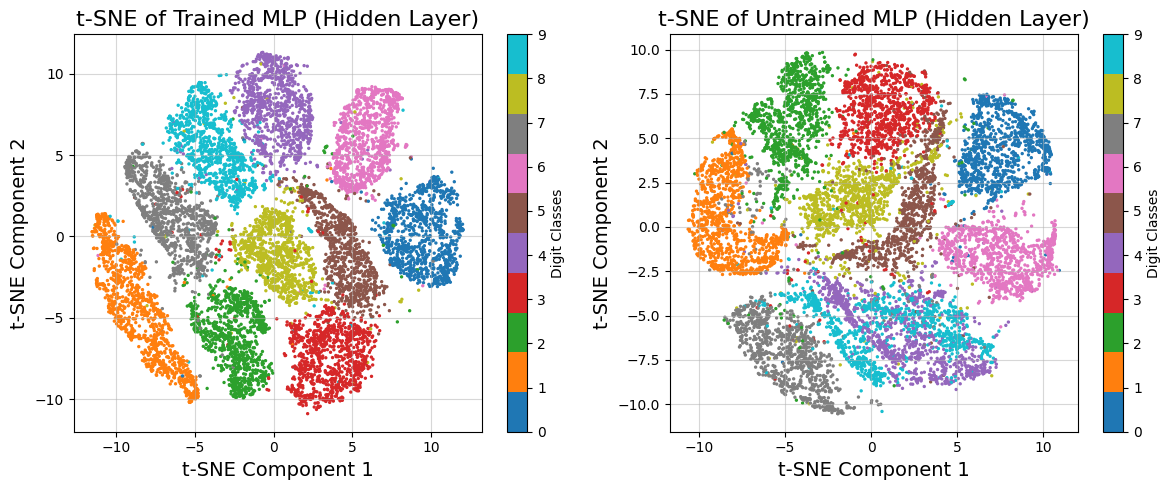

In [11]:
# Plotting t-SNE for trained and untrained models
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter1 = axes[0].scatter(X_trained_sk_tsne[:, 0], X_trained_sk_tsne[:, 1], c=y_trained, cmap='tab10', alpha=1, s=2)
axes[0].set_title('t-SNE of Trained MLP (Hidden Layer)', fontsize=16)
axes[0].set_xlabel('t-SNE Component 1', fontsize=14)
axes[0].set_ylabel('t-SNE Component 2', fontsize=14)
axes[0].grid(True,  alpha=0.5)
fig.colorbar(scatter1, ax=axes[0], label='Digit Classes')

scatter2 = axes[1].scatter(X_untrained_sk_tsne[:, 0], X_untrained_sk_tsne[:, 1], c=y_untrained, cmap='tab10', alpha=1, s=2)
axes[1].set_title('t-SNE of Untrained MLP (Hidden Layer)', fontsize=16)
axes[1].set_xlabel('t-SNE Component 1', fontsize=14)
axes[1].set_ylabel('t-SNE Component 2', fontsize=14)
axes[1].grid(True, alpha=0.5)
fig.colorbar(scatter2, ax=axes[1], label='Digit Classes')

plt.tight_layout()
plt.show()


## Observations
### t-SNE Plot of Trained MLP Model

- Distinct Clusters: The t-SNE plot of the trained model shows clear, distinct clusters, where each cluster corresponds to a specific digit (0–9). This demonstrates that the model has learned to group similar samples closely.
- Cluster Separation: The clusters are well-separated, indicating that the model has learned feature representations that effectively differentiate between digit classes.
- Dense Grouping: Within each cluster, points are densely grouped, showing that the model has reduced intra-class variation and is consistently able to identify similar features for each digit.

### t-SNE Plot of Untrained MLP Model
- Lack of Clusters: The t-SNE plot of the untrained model lacks distinct clusters for each digit. Without training, there’s no separation, as the model has not learned any useful features to distinguish between classes.
- Sparse and Mixed Representation: Points from different digit classes are scattered or intermixed randomly. This shows that the untrained model doesn’t have a structured representation of the data and cannot effectively differentiate between classes.

## Conclusion

By comparing these two plots, we conclude that the trained model has learned discriminative features, resulting in better separation and clustering of different digit classes, whereas the untrained model shows no such structure in the feature space.